In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Creating an optimisation with meta parameters
# 
# This notebook will explain how to set up an optimisation that uses metaparameters (parameters that control other parameters)


import bluepyopt as bpop
import bluepyopt.ephys as ephys
import pickle
from sciunit.scores import ZScore
from sciunit import TestSuite
from sciunit.scores.collections import ScoreArray
import sciunit
import numpy as np
from neuronunit.optimisation.optimization_management import dtc_to_rheo, switch_logic,active_values
from neuronunit.tests.base import AMPL, DELAY, DURATION

import quantities as pq
PASSIVE_DURATION = 500.0*pq.ms
PASSIVE_DELAY = 200.0*pq.ms
import matplotlib.pyplot as plt
from bluepyopt.ephys.models import ReducedCellModel
import numpy
from neuronunit.optimisation.optimization_management import test_all_objective_test
from neuronunit.optimisation.optimization_management import check_binary_match, three_step_protocol,inject_and_plot_passive_model
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
import copy

#hof_to_euclid(hof,MODEL_PARAMS,target)
MODEL_PARAMS["IZHI"].pop('C',None)
MODEL_PARAMS["IZHI"].pop('k',None)
MODEL_PARAMS["IZHI"].pop('vPeak',None)
MODEL_PARAMS["IZHI"].pop('vt',None)
MODEL_PARAMS["IZHI"].pop('vr',None)
MODEL_PARAMS["IZHI"].pop('d',None)
#sub_MODEL_PARAMS.pop('b',None)
'''
MODEL_PARAMS["IZHI"].pop('C',None)
MODEL_PARAMS["IZHI"].pop('k',None)
MODEL_PARAMS["IZHI"].pop('vr',None)
MODEL_PARAMS["IZHI"].pop('vPeak',None)



MODEL_PARAMS["IZHI"].pop('vt',None)
#MODEL_PARAMS["IZHI"].pop('a',None)
MODEL_PARAMS["IZHI"].pop('d',None)
'''
#MODEL_PARAMS["IZHI"].pop('c',None)

#MODEL_PARAMS["IZHI"].pop('C',None)
#MODEL_PARAMS["IZHI"].pop('k',None)

import numpy as np


simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=MODEL_PARAMS["IZHI"],backend="IZHI")  
simple_cell.backend = "IZHI"


# First we need to import the module that contains all the functionality to create electrical cell models

# If you want to see a lot of information about the internals, 
# the verbose level can be set to 'debug' by commenting out
# the following lines

# Setting up the cell
# ---------------------
# This is very similar to the simplecell example in the directory above. For a more detailed explanation, look there.

# For this example we will create two separate parameters to store the specific capacitance. One for the soma and one for the soma. We will put a metaparameter on top of these two to keep the value between soma and axon the same.

# The metaparameter, the one that will be optimised, will make sure the two parameters above keep always the same value

# And parameters that represent the maximal conductance of the sodium and potassium channels. These two parameters will be not be optimised but are frozen.

# ### Creating the template
# 
# To create the cell template, we pass all these objects to the constructor of the template.
# We *only* put the metaparameter, not its subparameters.


simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=MODEL_PARAMS["IZHI"],backend="IZHI")  
simple_cell.backend = "IZHI"


# Now we can print out a description of the cell

model = simple_cell
model.params = {k:np.mean(v) for k,v in model.params.items() }
from make_allen_tests import AllenTest

from sciunit.scores import ZScore
tests = pickle.load(open("processed_multicellular_constraints.p","rb"))
nu_tests = tests['Hippocampus CA1 pyramidal cell'].tests
nu_tests[0].score_type = ZScore

simulated_experiment = True
features = None
allen = True
from collections.abc import Iterable

if simulated_experiment:
    while features is None:
        aug_nu_tests, OM, target = test_all_objective_test(MODEL_PARAMS["IZHI"],model_type="IZHI",protocol={'allen':False,'elephant':True})
        target = three_step_protocol(target)
        if hasattr(target,'everything'):
            features = copy.copy(target.everything)
            
            check_list = {key:feat for key,feat in features.items() if not feat is None and type(feat) is not type(Iterable) and feat !=0 and feat !=1 }
            check_list.pop('depol_block_1.5x',None)
            check_list.pop('is_not_stuck_3.0x',None)
            check_list.pop('is_not_stuck_1.5x',None)
            scale = 2.0/len(check_list)
            if scale > 0.009999:
                print('not high enough definition')
                features = None
                continue
            
            if allen:
                simple_cell.allen = None
                simple_cell.allen = True

                tests = pickle.load(open("allen_NU_tests.p","rb"))
                print('allen cell',tests[0].name)
                nu_tests = tests[0]
                for t in nu_tests:
                    to_pop = []
                    if t.name in features.keys():
                        if features[t.name] is not None:
                            t.set_observation(features[t.name])
                            if t.observation['mean'] is not None:
                                t.observation['std'] = np.abs(np.mean(t.observation['mean']))
                        to_pop.append(t.name)
                        
                    [ features.pop(i,None) for i in to_pop ]
                '''
                more_tests = []
                for feat in features:    
                    if feat is not None:
                        at = AllenTest(name=feat)
                        at.set_observation(features[at.name])
                        if at.observation['mean'] is not None:
                            at.observation['std'] = np.abs(np.mean(t.observation['mean']))
                            more_tests.append(at)
                features = copy.copy(target.everything)
                nu_tests = [t for t in nu_tests.tests]
                nu_tests.extend(more_tests)
                
                '''
sub_MODEL_PARAMS = copy.copy(MODEL_PARAMS['IZHI'])

subset = list(sub_MODEL_PARAMS.keys())
tg = target.dtc_to_gene(subset_params=subset)
assert len(tg)==len(subset)

/home/user/anaconda3/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)


Random simulated data tests made
{'value': array(115.96069336) * pA}
{'value': array(2499.45343841) * ms}
{'mean': array(-65.22618636) * mV, 'std': array(1.42108547e-14) * mV}
{'value': array(28726516.10954762) * kg*m**2/(s**3*A**2)}
{'value': array(8.70085822e-08) * s**4*A**2/(kg*m**2)}
{'mean': array(0.00034) * s, 'std': array(0.) * s, 'n': 1}
{'value': array(49.84646474) * mV, 'mean': array(49.84646474) * mV, 'std': array(0.) * mV, 'n': 1}
{'mean': array(-28.7081258) * mV, 'std': array(0.) * mV, 'n': 1}
not high enough definition
Random simulated data tests made
{'value': array(129.91333008) * pA}
{'value': array(4436.62415769) * ms}
{'mean': array(-65.22618636) * mV, 'std': array(1.42108547e-14) * mV}
{'value': array(28086896.43038065) * kg*m**2/(s**3*A**2)}
{'value': array(1.57960641e-07) * s**4*A**2/(kg*m**2)}
{'mean': array(0.00032) * s, 'std': array(0.) * s, 'n': 1}
{'value': array(48.10107642) * mV, 'mean': array(48.10107642) * mV, 'std': array(0.) * mV, 'n': 1}
{'mean': array

In [2]:
features = target.everything


for key,feat in features.items():
    if isinstance(feat, int):
        print(key,feat)
features
nu_tests;

In [3]:

big_list = []
for tt in aug_nu_tests.values():
    tt.core = None
    tt.core = True
    big_list.append(tt)
big_list.extend(nu_tests)
nu_tests = big_list

In [4]:
#big_list = []
#for tt in nu_tests:
#    big_list.append(tt)
#big_list.extend(more_tests)
#nu_tests = big_list
#    feature_name = '%s' % (tt.name)
#    print(feature_name)
import efel
import pandas as pd
import seaborn as sns
list(efel.getFeatureNames());

def basic_expVar(trace1, trace2):
    # https://github.com/AllenInstitute/GLIF_Teeter_et_al_2018/blob/master/query_biophys/query_biophys_expVar.py
    '''This is the fundamental calculation that is used in all different types of explained variation.  
    At a basic level, the explained variance is calculated between two traces.  These traces can be PSTH's
    or single spike trains that have been convolved with a kernel (in this case always a Gaussian)
    Input:
        trace 1 & 2:  1D numpy array containing values of the trace.  (This function requires numpy array
                        to ensure that this is not a multidemensional list.)
    Returns:
        expVar:  float value of explained variance
    '''
    
    var_trace1=np.var(trace1)
    var_trace2=np.var(trace2)
    var_trace1_minus_trace2=np.var(trace1-trace2)

    if var_trace1_minus_trace2 == 0.0:
        return 1.0
    else:
        return (var_trace1+var_trace2-var_trace1_minus_trace2)/(var_trace1+var_trace2)

In [5]:
 
class NUFeatureAllen(object):
    def __init__(self,test,model,cnt,target,check_list,spike_obs,print_stuff=False):
        self.test = test
        self.model = model
        self.check_list = check_list
        self.spike_obs = spike_obs
        self.cnt = cnt
        self.target = target
        self.print_stuff = print_stuff
    def calculate_score(self,responses):
        if not 'features' in responses.keys():# or not 'model' in responses.keys():
            return 100.0
        check_list = self.check_list

    
        features = responses['features']

        
        feature_name = self.test.name
        if feature_name not in features.keys():
            return 100.0
        
        if features[feature_name] is None:
            return 100.0
            
        if type(features[self.test.name]) is type(Iterable):
            features[self.test.name] = np.mean(features[self.test.name])
        self.test.observation['std'] = np.abs(np.mean(self.test.observation['mean']))
        self.test.observation['mean'] = np.mean(self.test.observation['mean'])            
        self.test.set_prediction(np.mean(features[self.test.name]))
        
        if 'Spikecount_3.0x'==feature_name or 'Spikecount_1.5x'==feature_name:
            delta = np.abs(features[self.test.name]-np.mean(self.test.observation['mean']))

            
            return delta
        else:
            delta0 = np.abs(features['Spikecount_3.0x']-np.mean(self.spike_obs[0]['mean']))
            delta1 = np.abs(features['Spikecount_1.5x']-np.mean(self.spike_obs[1]['mean']))
            #print('should not get here')
            #if self.print_stuff:
            #    print(features['Spikecount_3.0x'],np.mean(self.spike_obs[0]['mean']))
            #    print(features['Spikecount_1.5x'],np.mean(self.spike_obs[1]['mean']))


            #else:

            #if hasattr(self.test,'core'):
            #    score = self.calculate_score_core(responses)
            #    score = 0.000925*score
            #    return score 
            '''
            if self.cnt==287:# 286 spike_width2_3.0x
                delta0 = 0.03*(1.0-float(basic_expVar(responses['dtc'].vm15,self.target.vm15)))
                delta1 = 0.03*(1.0-float(basic_expVar(responses['dtc'].vm30,self.target.vm30)))
                return delta0+delta1
            if self.cnt==286:
                delta = 0.03*(1.0-basic_expVar(responses['dtc'].vmrh,self.target.vmrh))
                return float(delta)                
            print(self.cnt,feature_name)
            '''

            if feature_name in check_list:
                if features[feature_name] is None:
                    return 100.0
                score_gene = self.test.feature_judge()
                if score_gene is not None:
                    if score_gene.log_norm_score is not None:

                        delta = np.abs(float(score_gene.log_norm_score))
                        if delta==np.inf:
                            if score_gene.raw is not None:
                                delta =  np.abs(float(score_gene.raw))
                    else:
                        if score_gene.raw is not None:
                            delta =  np.abs(float(score_gene.raw))
                        else:
                            delta = np.abs(features[feature_name]-np.mean(self.test.observation['mean']))
                            
                else:
                    delta = np.abs(features[feature_name]-np.mean(self.test.observation['mean']))

                if np.isnan(delta):

                    delta = 100.0
                if delta is None:

                    delta = 100.0
                score = 0.000001*delta
               
          
                if 'AP_rise_rate_change_1.5x'==feature_name:
                    score = score/10.0

                if 'AP1_width_1.5'==feature_name:
                    score = score/100.0
                if 'AHP_depth_diff_1.5x'==feature_name:
                    score = score/100.0
                if 'AP2_AP1_begin_width_diff_1.5x'==feature_name:
                    score = score/1000000000.0
                if 'amp_drop_first_second_1.5x'==feature_name:
                    score = score/1000000000.0

                if 'AP_duration_half_width_change_3.0x'==feature_name:
                    score = score/1000000000.0

                if 'spike_width2_3.0x'==feature_name:
                    score = score/1000000000.0

                if 'AP_duration_half_width_change_3.0x'==feature_name:
                    score = score/1000000000.0

                if 'AP_duration_half_width_change_1.5x'==feature_name:
                    score = score/10000000000.0
                    

                if 'AP_duration_change_3.0x'==feature_name:
                    score = score/1000000000.0


                if 'AP_duration_half_width_change_3.0x'==feature_name:
                    score = score/1000000000.0
                    
                    
                if 'AP_duration_half_width_change_1.5x'==feature_name:
                    score = score/100.0
                if 'decay_time_constant_after_stim_1.5x'==feature_name:
                    score = score/100.0
                if 'AP_duration_half_width_change_1.5x'==feature_name:
                    score = score/100.0

                #if score>1.0:
                #    print(score,'hit',feature_name)
                #    score = score/100.0
                #    print(self.cnt)
                return score+(delta0+delta1)

        print(feature_name,'\n\n\n\n leaked case \n\n\n\n')

objectives = []
spike_obs = []#[None for i in range(0,1) ]
for tt in nu_tests:
    if 'Spikecount_3.0x' == tt.name:# or 'spike_width2_3.0x' in tt.name or 'AHP_time_from_peak_3.0x' in tt.name:# or 'isi' in tt.name or 'cv' in tt.name:
        spike_obs.append(tt.observation)
    if 'Spikecount_1.5x' == tt.name:
        spike_obs.append(tt.observation)
spike_obs = sorted(spike_obs, key=lambda k: k['mean'],reverse=True)

for cnt,tt in enumerate(nu_tests):
    feature_name = '%s' % (tt.name)
    if feature_name in check_list:
        if 'Spikecount_3.0x' == tt.name or 'Spikecount_1.5x' == tt.name:# or 'spike_width2_3.0x' in tt.name or 'AHP_time_from_peak_3.0x' in tt.name:# or 'isi' in tt.name or 'cv' in tt.name:
            ft = NUFeatureAllen(tt,model,cnt,target,check_list,spike_obs)
            objective = ephys.objectives.SingletonObjective(
                feature_name,
                ft)
            print(cnt,feature_name)
            objectives.append(objective)


        
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives) 
        
        


# ### Creating the cell evaluator
# 
# We will need an object that can use these objective definitions to calculate the scores from a protocol response. This is called a ScoreCalculator.




lop={}
from bluepyopt.parameters import Parameter
for k,v in MODEL_PARAMS["IZHI"].items():
    p = Parameter(name=k,bounds=v,frozen=False)
    lop[k] = p

print(lop)
simple_cell.params = lop

96 Spikecount_1.5x
255 Spikecount_3.0x
{'a': <bluepyopt.parameters.Parameter object at 0x7f00d02ca210>, 'b': <bluepyopt.parameters.Parameter object at 0x7f00d0203310>, 'c': <bluepyopt.parameters.Parameter object at 0x7f00d02caa90>}


INFO:__main__:gen	nevals	avg   	std    	min	max
1  	100   	102.93	85.2021	2  	200


INFO:__main__:2  	17    	102.423	85.2909	2  	200
INFO:__main__:3  	15    	32.8325	44.4176	2  	200
INFO:__main__:4  	23    	11.9606	10.4221	2  	63 
INFO:__main__:5  	29    	5.2266 	5.12964	2  	34 
INFO:__main__:6  	20    	5.45813	14.2231	2  	200
INFO:__main__:7  	27    	3.58621	13.9495	2  	200
INFO:__main__:8  	9     	3.26601	3.08631	2  	44 
INFO:__main__:9  	14    	3.80296	4.3255 	2  	43 
INFO:__main__:10 	15    	5.22167	4.02151	2  	37 
INFO:__main__:11 	16    	3.76355	14.1164	2  	200
INFO:__main__:12 	23    	3.97044	3.60064	1  	41 
INFO:__main__:13 	12    	5.4335 	2.5901 	1  	20 
INFO:__main__:14 	31    	4.49754	14.4111	1  	200
INFO:__main__:15 	21    	3.27586	4.77088	1  	42 
INFO:__main__:16 	16    	4.50246	3.76446	1  	20 
INFO:__main__:17 	20    	3.75369	19.7733	1  	200
INFO:__main__:18 	30    	3.4532 	5.0769 	1  	42 
INFO:__main__:19 	30    	5.60591	4.69906	1  	44 
INFO:__main__:20 	19    	2.41872	2.64241	1  	16 
INFO:__main__:21 	23    	5.89163	14.189 	1  	200
INFO:__main__:22 	15

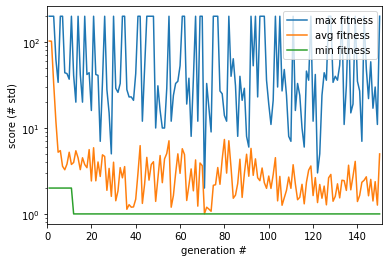

In [6]:


# Combining everything together we have a CellEvaluator. The CellEvaluator constructor has a field 'parameter_names' which contains the (ordered) list of names of the parameters that are used as input (and will be fitted later on).
sweep_protocols = []
for protocol_name, amplitude in [('step1', 0.05)]:

    protocol = ephys.protocols.SweepProtocol(protocol_name, [None], [None])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

MODEL_PARAMS["IZHI"]
cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model=simple_cell,
        param_names=MODEL_PARAMS["IZHI"].keys(),
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc,
        sim='euler')
simple_cell.params_by_names(MODEL_PARAMS["IZHI"].keys())
simple_cell.params;



# ## Setting up and running an optimisation
# 
# Now that we have a cell template and an evaluator for this cell, we can set up an optimisation.


MU = 100
optimisation = bpop.optimisations.DEAPOptimisation(
        evaluator=cell_evaluator,
        offspring_size = MU,
        map_function = dask_map_function,
        selector_name='IBEA',mutpb=0.04,cxpb=0.15)

final_pop, hall_of_fame, logs_early, hist_hearly = optimisation.run(max_ngen=150)#, cp_filename='results_100.p',continue_cp=False)

gen_numbers = logs_early.select('gen')
min_fitness = logs_early.select('min')
max_fitness = logs_early.select('max')
avg_fitness = logs_early.select('avg')

plt.clf()
plt.plot(gen_numbers, max_fitness, label='max fitness')
plt.plot(gen_numbers, avg_fitness, label='avg fitness')
plt.plot(gen_numbers, min_fitness, label='min fitness')

plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.yscale('log')

plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
#plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
plt.show()

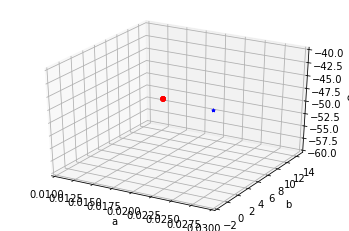

NameError: name 'hist' is not defined

In [7]:
sub_MODEL_PARAMS = copy.copy(MODEL_PARAMS['IZHI'])


sub_MODEL_PARAMS
hof_to_euclid(hall_of_fame,sub_MODEL_PARAMS,target)
sub_MODEL_PARAMS
hof_to_euclid(list(hist.genealogy_history.values()),sub_MODEL_PARAMS,target)
subset = list(sub_MODEL_PARAMS.keys())
tg = target.dtc_to_gene(subset_params=subset)
tg
MODEL_PARAMS['IZHI']
tg

In [ ]:
objectives2 = []
for cnt,tt in enumerate(nu_tests):
    feature_name = '%s' % (tt.name)
    if feature_name in check_list:
        ft = NUFeatureAllen(tt,model,cnt,target,check_list,spike_obs,print_stuff=True)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            ft)
        objectives2.append(objective)


        
score_calc2 = ephys.objectivescalculators.ObjectivesCalculator(objectives2) 

MODEL_PARAMS["IZHI"]
cell_evaluator2 = ephys.evaluators.CellEvaluator(
        cell_model=simple_cell,
        param_names=list(MODEL_PARAMS["IZHI"].keys()),
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc2,
        sim='euler')
simple_cell.params_by_names(MODEL_PARAMS["IZHI"].keys())

del optimisation.evaluator
optimisation.evaluator = cell_evaluator2
simple_cell.params;






In [ ]:
#cp['population']
#for ind in 
'''
import pickle
with open('evaluator.p','wb') as f:
    pickle.dump(cell_evaluator2,f)

with open('evaluator.p','rb') as f:
    cell_evaluator2 = pickle.load(f)    
'''    

In [ ]:



MU = 100
cp = {}
cp['halloffame'] = hall_of_fame
cp['population'] = final_pop
#seed_pop = cp['halloffame']
#cp = pickle.load(open('results_100.p', "rb"))

#seed_pop.extend(cp['pop'])
optimisation = bpop.optimisations.DEAPOptimisation(
        evaluator=cell_evaluator2,
        offspring_size = MU,
        map_function = dask_map_function,
        selector_name='IBEA',mutpb=0.045,cxpb=0.15,
        seeded_pop=[cp['halloffame'],cp['population']])
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=100)


In [ ]:


# The optimisation has return us 4 objects: final population, hall of fame, statistical logs and history. 
# 
# The final population contains a list of tuples, with each tuple representing the two parameters of the model


#print('Final population: ', final_pop)


# The best individual found during the optimisation is the first individual of the hall of fame

best_ind = hall_of_fame[0]
#print('Best individual: ', best_ind)
#print('Fitness values: ', best_ind.fitness.values)


# We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dict of the parameters


best_ind_dict = cell_evaluator.param_dict(best_ind)
#print(cell_evaluator.evaluate_with_dicts(best_ind_dict))


model = cell_evaluator.cell_model
cell_evaluator.param_dict(best_ind)
model.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}



opt = model.model_to_dtc()
opt.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}

check_binary_match(target,opt)
inject_and_plot_passive_model(opt,second=target)


# As you can see the evaluation returns the same values as the fitness values provided by the optimisation output. 
# We can have a look at the responses now.

# In[ ]:


#plot_responses(twostep_protocol.run(cell_model=simple_cell, param_values=best_ind_dict, sim=nrn))
 


# Let's have a look at the optimisation statistics.
# We can plot the minimal score (sum of all objective scores) found in every optimisation. 
# The optimisation algorithm uses negative fitness scores, so we actually have to look at the maximum values log.

gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 

In [ ]:
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')

plt.clf()
plt.plot(gen_numbers, max_fitness, label='max fitness')
plt.plot(gen_numbers, avg_fitness, label='avg fitness')
plt.plot(gen_numbers, min_fitness, label='min fitness')

plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.yscale('log')

plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
#plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
plt.show()

In [ ]:
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')

plt.clf()
fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(1,1)

plt.plot(gen_numbers, min_fitness, label='min fitness')
#ax.semilogy()
#ax.set_yscale('log')
plt.yscale('log')

plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
#plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
plt.show()

In [ ]:
inject_and_plot_passive_model(opt,second=target,plotly=False)
best_ind_dict = cell_evaluator.param_dict(best_ind)
objectives = cell_evaluator.evaluate_with_dicts(best_ind_dict)

In [ ]:
best_ind_dict = cell_evaluator.param_dict(best_ind)
objectives = cell_evaluator.evaluate_with_dicts(best_ind_dict)

model = cell_evaluator.cell_model
cell_evaluator.param_dict(best_ind)
model.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}

opt = model.model_to_dtc()
opt.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}
from neuronunit.optimisation.optimization_management import dtc_to_rheo, inject_and_plot_model30,check_bin_vm30,check_bin_vm15
opt = dtc_to_rheo(opt)
opt.rheobase
opt.attrs;
vm301,vm151,_,_,target = inject_and_plot_model30(target)
vm302,vm152,_,_,opt = inject_and_plot_model30(opt)

In [ ]:
from neuronunit.optimisation.optimization_management import dtc_to_rheo, inject_and_plot_model30,check_bin_vm30,check_bin_vm15
check_bin_vm30(target,opt)
check_bin_vm15(target,opt)





In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



def hof_to_euclid(hof,MODEL_PARAMS,target):
    lengths = {}
    tv = 1
    cnt = 0
    constellation0 = hof[0]
    constellation1 = hof[1]
    subset = list(sub_MODEL_PARAMS.keys())
    tg = target.dtc_to_gene(subset_params=subset)
    if len(MODEL_PARAMS)==1:
        
        ax = plt.subplot()
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))

            x = [h[cnt] for h in hof]
            y = [0 for h in hof]
            ax.set_xlim(v[0],v[1])
            ax.set_xlabel(k)
            tgene = tg[cnt]
            yg = 0

        ax.scatter(x, y, c='b', marker='o',label='samples')
        ax.scatter(tgene, yg, c='r', marker='*',label='target')
        ax.legend()

        plt.show()
    
    
    if len(MODEL_PARAMS)==2:
        
        ax = plt.subplot()
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))
                
            if cnt==0:
                tgenex = tg[cnt]
                x = [h[cnt] for h in hof]
                ax.set_xlim(v[0],v[1])
                ax.set_xlabel(k)
            if cnt==1:
                tgeney = tg[cnt]

                y = [h[cnt] for h in hof]
                ax.set_ylim(v[0],v[1])
                ax.set_ylabel(k)
            cnt+=1

        ax.scatter(x, y, c='r', marker='o',label='samples',s=5)
        ax.scatter(tgenex, tgeney, c='b', marker='*',label='target',s=11)

        ax.legend()

        plt.show()
    #print(len(MODEL_PARAMS))
    if len(MODEL_PARAMS)==3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))
        
            if cnt==0:
                tgenex = tg[cnt]

                x = [h[cnt] for h in hof]
                ax.set_xlim(v[0],v[1])
                ax.set_xlabel(k)
            if cnt==1:
                tgeney = tg[cnt]

                y = [h[cnt] for h in hof]
                ax.set_ylim(v[0],v[1])
                ax.set_ylabel(k)
            if cnt==2:
                tgenez = tg[cnt]

                z = [h[cnt] for h in hof]
                ax.set_zlim(v[0],v[1])
                ax.set_zlabel(k)

            cnt+=1
        ax.scatter(x, y, z, c='r', marker='o')
        ax.scatter(tgenex, tgeney,tgenez, c='b', marker='*',label='target',s=21)

        plt.show()
        
sub_MODEL_PARAMS = copy.copy(MODEL_PARAMS['IZHI'])


sub_MODEL_PARAMS
hof_to_euclid(hall_of_fame,sub_MODEL_PARAMS,target)
sub_MODEL_PARAMS
hof_to_euclid(final_pop,sub_MODEL_PARAMS,target)
subset = list(sub_MODEL_PARAMS.keys())
tg = target.dtc_to_gene(subset_params=subset)
tg
MODEL_PARAMS['IZHI']
tg

In [ ]:
#for gene in list(hist.genealogy_history.values()):
hof_to_euclid(list(hist.genealogy_history.values()),sub_MODEL_PARAMS,target)
sub_MODEL_PARAMS

In [ ]:
def basic_expVar(trace1, trace2):
    # https://github.com/AllenInstitute/GLIF_Teeter_et_al_2018/blob/master/query_biophys/query_biophys_expVar.py
    '''This is the fundamental calculation that is used in all different types of explained variation.  
    At a basic level, the explained variance is calculated between two traces.  These traces can be PSTH's
    or single spike trains that have been convolved with a kernel (in this case always a Gaussian)
    Input:
        trace 1 & 2:  1D numpy array containing values of the trace.  (This function requires numpy array
                        to ensure that this is not a multidemensional list.)
    Returns:
        expVar:  float value of explained variance
    '''
    
    var_trace1=np.var(trace1)
    var_trace2=np.var(trace2)
    var_trace1_minus_trace2=np.var(trace1-trace2)

    if var_trace1_minus_trace2 == 0.0:
        return 1.0
    else:
        return (var_trace1+var_trace2-var_trace1_minus_trace2)/(var_trace1+var_trace2)
print(basic_expVar(target.vm15, opt.vm15))
print(basic_expVar(target.vm30, opt.vm30))

In [ ]:
opt = dtc_to_rheo(opt)
print(opt.rheobase)
print(target.rheobase)

In [ ]:

check_binary_match(opt,target,plotly=False,snippets=False)
check_binary_match(opt,target,plotly=False,snippets=True)
print(basic_expVar(target.vmrh, opt.vmrh), 'variancce explained ratio at rheobase')


In [ ]:
params = {}
params['injected_square_current'] = {}
#if v.name in str('RestingPotentialTest'):
params['injected_square_current']['delay'] = PASSIVE_DELAY
params['injected_square_current']['duration'] = PASSIVE_DURATION
params['injected_square_current']['amplitude'] = 0.0*pq.pA    

In [ ]:

opt_model = opt.dtc_to_model()
opt_model.inject_square_current(params)
opt_vm = opt_model.get_membrane_potential()
opt_vm[-1]

In [ ]:
target_model = target.dtc_to_model()
target_model.inject_square_current(params)
target_vm = target_model.get_membrane_potential()
target_vm[-1]

In [ ]:
best_ind = hall_of_fame[1]
#print('Best individual: ', best_ind)
#print('Fitness values: ', best_ind.fitness.values)


# We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dict of the parameters


best_ind_dict = cell_evaluator.param_dict(best_ind)
#print(cell_evaluator.evaluate_with_dicts(best_ind_dict))


model = cell_evaluator.cell_model
dtc= model.model_to_dtc()
opt = dtc_to_rheo(opt)
print(opt.rheobase)
print(target.rheobase)

In [ ]:
#model.rheobase
objectives

In [ ]:

best_ind_dict = cell_evaluator.param_dict(best_ind)
objectives = cell_evaluator.evaluate_with_dicts(best_ind_dict)

objectives2 = cell_evaluator2.evaluate_with_dicts(best_ind_dict)


In [ ]:
import pandas as pd
import seaborn as sns
logbook = logs
#scores = [ m for m in logs ]
'''
list_of_dicts = []
df1 = pd.DataFrame()
genes=[]
for _,v in hist.genealogy_history.items():
    genes.append(v.fitness.values)
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)

'''
#MU =14
genes=[]
min_per_generations = []
for i,v in hist.genealogy_history.items():
    if i%MU==0:
        min_per_gen = sorted([(gene,np.min(gene)) for gene in genes],key=lambda x: x[1])
        min_per_generations.append(min_per_gen[0][0])
        genes =[]
    genes.append(v.fitness.values)
    
df2 = pd.DataFrame()
scores = []
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    print([i[j] for i in min_per_generations ])
    df2[index] = pd.Series([i[j] for i in min_per_generations ])#, index=df1.index)
df2    


In [ ]:
number=int(np.sqrt(len(df2.columns)))

In [ ]:
import math
box = int(np.sqrt(len(objectives)))
fig,axes = plt.subplots(box,box+1,figsize=(20,20))#math.ceil(len(objectives)/2+1),figsize=(20,20))
#axes[0,0].plot(scores)
#axes[0,0].plot(gen_numbers, min_fitness, label='min fitness')

axes[0,0].set_title('Observation/Prediction Disagreement')
for i,c in enumerate(df2.columns):
    ax = axes.flat[i+1]
    history = df2[c]
    #mn = mean[k.name] 
    #st = std[k.name] 
    #history = [(j[i]-mn)/st for j in scores ]
    #ax.axhline(y=mn , xmin=0.02, xmax=0.99,color='red',label='best candidate sampled')

    #ax.axvline(x=min_x , ymin=0.02, ymax=0.99,color='blue',label='best candidate sampled')
    ax.plot(history)
    ax.set_title(str(c))
    #bigger = np.max([np.max(history),mn])
    #smaller = np.max([np.min(history),mn])

    #ax.set_ylim([np.min(history),np.max(history)])
    #ax.set_ylabel(str(front[0].dtc.tests[i].observation['std'].units))
axes[0,0].set_xlabel("Generation")
axes[0,0].set_ylabel("standardized error")

plt.tight_layout()
#if figname is not None:
#    plt.savefig(figname)
#else:
plt.show()

In [ ]:

logbook = logs
#scores = [ m for m in logs ]
list_of_dicts = []
df1 = pd.DataFrame()
genes=[]
for _,v in hist.genealogy_history.items():
    genes.append(v.fitness.values)
for j,i in enumerate(objectives2.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)


    
#if normalize:
#    a = (a - mean(a)) / (std(a) * len(a))
#    v = (v - mean(v)) /  std(v)

df1=(df1-df1.mean())/df1.std()

corr = df1.corr()#.normalize()
fig =plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)#, annot=True)
plt.show()
print(np.sum(np.sum(corr)))

In [ ]:

    
logbook = logs
#scores = [ m for m in logs ]
list_of_dicts = []
df1 = pd.DataFrame()
genes=[]
for _,v in hist.genealogy_history.items():
    genes.append(v.fitness.values)
for j,i in enumerate(objectives2.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)


    
#if normalize:
#    a = (a - mean(a)) / (std(a) * len(a))
#    v = (v - mean(v)) /  std(v)

df1=(df1-df1.mean())/df1.std()

corr = df1.corr()#.normalize()
fig =plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)#, annot=True)
plt.show()
print(np.sum(np.sum(corr)))

In [ ]:
hist.genealogy_history.keys();

In [ ]:
hist.genealogy_tree.keys();

In [ ]:
import networkx
graph = networkx.DiGraph(hist.genealogy_tree)
graph = graph.reverse()     # Make the graph top-down
per_generation = [(gen,hist.genealogy_history[gen].fitness.values) for gen in graph]

In [ ]:
per_generation

In [ ]:
graph.nodes

In [ ]:
cp['halloffame'][-1].fitness.values

In [ ]:
cp['halloffame'][0].fitness.values

In [ ]:
cp['population'][-1].fitness.values

In [ ]:
final_pop 
hall_of_fame[-1].fitness.values

In [ ]:
len(hall_of_fame)

In [ ]:
plt.plot([i for i in range(len(hall_of_fame),0,-1)],[np.sum(i.fitness.values) for i in hall_of_fame])

In [ ]:
plt.plot([i for i in range(0,len(hall_of_fame))],[np.sum(hall_of_fame[i].fitness.values) for i in range(len(hall_of_fame)-1,-1,-1)])

In [ ]:
genes=[]

for v in hall_of_fame:
    #v = hall_of_fame[j]
    genes.append(v.fitness.values)

#for i in 
#    plt.plot([i for i in range(0,len(hall_of_fame))],[hall_of_fame[i].fitness.values[j] for i in range(len(hall_of_fame)-1,-1,-1)])
#    plt.show()
df1 = pd.DataFrame()

In [ ]:
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)

df1=(df1-df1.mean())/df1.std()

corr = df1.corr()
fig =plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)#, annot=True)
plt.show()

In [ ]:
for j,i in enumerate(objectives2.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)

df1=(df1-df1.mean())/df1.std()

corr = df1.corr()
fig =plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)#, annot=True)
plt.show()